In [2]:
import numpy as np
import sklearn
from sklearn.covariance import EmpiricalCovariance
import scipy

In [3]:
def SM(x,y):
    return np.exp(np.dot(x,y))

def cnorm_sq(A,x):
    Ax = np.matmul(A,x)
    output = 0
    for elmt in Ax:
        output+=(elmt)**2
    return output


def MSE_SM_cexp(x,y,A):
    # left = (SM(x,y))**2
    # right = np.exp(cnorm_sq(A,x))*np.exp(cnorm_sq(np.linalg.inv(A), y))*((SM(x,y))**2) - 1
    left = np.exp(np.linalg.norm(np.matmul(A,x) + np.matmul(np.linalg.inv(A), y))**2)*SM(x,y)**2
    right = (1- np.exp(-1*np.linalg.norm(np.matmul(A,x) + np.matmul(np.linalg.inv(A), y))**2))**2
    # right = np.exp(cnorm_sq(A,x) + np.exp(cnorm_sq(np.linalg.inv(A), y)))*((SM(x,y))**2) - 1
    print('left: ', left)
    print('right: ',right)
    return left*right

def MSE_SM_cexp_v2(x,y,A):
    term1 = np.exp(-1*(cnorm_sq(A,x)))

def MSE_SM_prf(x,y):
    x = np.array(x)
    y = np.array(y)
    z = x+y
    term1 = np.exp((np.linalg.norm(z))**2)
    term2 = (SM(x,y))**2
    term3 = 1-np.exp(-1*(np.linalg.norm(z))**2)
    return term1*term2*term3

def MSE_SM_trig(x,y):
    z = np.array(x) + np.array(y)
    delt = np.array(x) - np.array(y)
    term1 = np.exp((np.linalg.norm(z))**2)
    term2 = (SM(x,y))**(-2)
    term3 = (1-np.exp(-1*(np.linalg.norm(delt))**2))**2
    return term1*term2*term3

In [4]:
"""
Code for the SM_cexp estimator
"""

def phi_cexp(A,x,omegas):
    # print(A)
    # print(x)
    term1 = np.exp((-1/2)*cnorm_sq(A,x))
    term2 = np.array([np.exp(np.dot(omegas[i], np.matmul(A,x))) for i in range(len(omegas))])
    # print('phi_cexp term 1: ', term1)
    # print('phi_cexp term 2: ', term2)
    # print('cnorm: ',cnorm_sq(A,x))

    return term1*term2

def SM_cexp(A,x,y,m):
    omegas = np.random.normal(0, 1, (m, len(x)))
    phi_x = phi_cexp(A,x,omegas)
    phi_y = phi_cexp(np.linalg.inv(np.matrix.transpose(A)), y, omegas)

    return (1/m)*np.dot(phi_x, phi_y)


def phi_cexp_plus(A,x,omegas):
    term1 = np.exp((-1/2)*cnorm_sq(A,x))
    temp1 = np.array([np.exp(np.dot(omegas[i], np.matmul(A,x))) for i in range(len(omegas))])
    temp2 = np.array([np.exp(-1*np.dot(omegas[i], np.matmul(A,x))) for i in range(len(omegas))])

    term2 = np.concatenate((temp1, temp2))

    return term1*term2

def SM_cexp_plus(A,x,y,m):
    omegas = np.random.normal(0, 1, (m, len(x)))
    phi_x = phi_cexp_plus(A,x,omegas)
    phi_y = phi_cexp_plus(np.linalg.inv(np.matrix.transpose(A)), y, omegas)

    return (1/(2*m))*np.dot(phi_x, phi_y)





def choose_A(mu_x, mu_y, max=10**10):
    v = []
    for i in range(len(mu_x)):
        if mu_x[i] == 0 and mu_y[i] == 0:
            v.append(1)
        elif mu_x[i] == 0:
            # make v[i] very big
            v.append(max)
        elif mu_y[i] == 0:
            # make v[i] very small
            v.append(1/max)
        else:
            v.append(np.sqrt(np.abs(mu_y[i]/mu_x[i])))

    return np.diag(v)


def choose_A_with_var(mu_x, mu_y, Cov_x, Cov_y):
    v = []
    for i in range(len(mu_x)):
        val = ((mu_y[i]**2 + Cov_y[i][i]**2)/(mu_x[i]**2 + Cov_x[i][i]**2))**(1/4)
        v.append(val)

    return np.diag(v)




In [5]:
"""
Verifying that MSE_SM_cexp == MSE_SM_prf when A = Id
"""

x = [1,2,3,4,5]
y = [5,4,3,2,1]
A = np.identity(len(x))
val1 = MSE_SM_cexp(x,y,A)
val2 = MSE_SM_prf(x,y)
print('val1: ',val1)
print('val2: ',val2)

left:  3.74645461450278e+108
right:  1.0
val1:  3.74645461450278e+108
val2:  3.74645461450278e+108


In [6]:
"""
Verifying that MSE_SM_cexp < MSE_SM_prf when A is set to be the optimal real matrix and x, y are constant
"""
# x = [.0000001,-.00000001,.00001,-.000004,.000005]
# y = [.0000005,1,.000001,-.000002,.0000001]
x = [10,0.0001,10,0.0001,10]
y = [0.0001,10,0.0001,10,0.0001]
A = choose_A(x, y)
# A = np.identity(len(x))
m = 128
# A = np.diag([np.sqrt(5), np.sqrt(2), np.sqrt(1), np.sqrt(1/2), np.sqrt(1/5)], k=0)
# A = np.diag([np.sqrt(100), np.sqrt(100), np.sqrt(100), np.sqrt(100), np.sqrt(100)], k=0)

val1 = (1/m)*MSE_SM_cexp(x,y,A)
val2 = (1/m)*MSE_SM_prf(x,y)
val3 = (1/(2*m))*MSE_SM_trig(x,y)

print('val1: ',val1)
print('val2: ',val2)
print('val3: ',val3)

left:  1.0304545339535167
right:  0.00039209253881260697
val1:  3.1565119870999695e-06
val2:  1.118708385235723e+215
val3:  5.482782375125992e+214


In [ ]:
"""
Experimentally verifying the theoretical MSE values we obtained
"""
# x = [.0000001,-.00000001,.00001,-.000004,.000005]
# y = [.0000005,1,.000001,-.000002,.0000001]
# A = np.diag([np.sqrt(np.abs(y[i]/x[i])) for i in range(len(x))])
x = [10,0.0001,10,0.0001,10]
y = [0.0001,10,0.0001,10,0.0001]
A = choose_A(x, y)
# A = np.identity(len(x))
m = 128
# A = np.diag([np.sqrt(5), np.sqrt(2), np.sqrt(1), np.sqrt(1/2), np.sqrt(1/5)], k=0)
# A = np.diag([np.sqrt(100), np.sqrt(100), np.sqrt(100), np.sqrt(100), np.sqrt(100)], k=0)
# A = np.identity(len(x))

k = 10000
true_SMs = []
pred_SMs = []
for i in range(k):
    true_SMs.append(SM(x,y))
    pred_SMs.append(SM_cexp(A, x, y, m))

print('True SM: ', true_SMs[0])
print(max(pred_SMs), pred_SMs[:20])

squared_errors = [(true_SMs[i] - pred_SMs[i])**2 for i in range(len(true_SMs))]
print('MSE: ', np.mean(squared_errors))


True SM:  1.005012520859401
1.0553447257843356 [0.9851218007801144, 0.9847177871247306, 1.0043063026165364, 0.9952563675791856, 1.007742280322237, 1.0201458973388329, 0.9911350461233343, 1.0123360637777665, 1.0002435785257893, 1.0158243724849356, 0.9989800118512148, 1.017921647949557, 0.9996720115640443, 0.9911308252285937, 1.0097047647657051, 1.0064623919413536, 1.0056486282948711, 1.0091307424048321, 0.9977896150352197, 1.0093148648173575]
MSE:  0.00015854864566432368


In [14]:
"""
Testing the method for various settings of A when x, y are independently sampled from two normal distributions
"""

k = 250
m = 1024
d = 50
itrs = 1

MSEs_1 = []
MSEs_2 = []
MSEs_3 = []

Max_relative_errors_1 = []
Max_relative_errors_2 = []
Max_relative_errors_3 = []

for itr in range(itrs):

    """
    Uncomment to resample
    """
    # mu_x = np.random.normal(0, 100, size=d)
    # mu_y = np.random.normal(0, 100, size=d)
    mu_x = np.random.laplace(0, .01, size=d)
    mu_y = np.random.laplace(0, .01, size=d)
    # mu_x = np.zeros(d)
    # mu_y = np.zeros(d)
    # s_x = 5/((np.linalg.norm(mu_x)))
    # s_y = .5/((np.linalg.norm(mu_y)))
    # mu_x = s_x*mu_x
    # mu_y = s_y*mu_y

    vars_x = np.random.gamma(.1, scale=1.0, size=len(mu_x))
    vars_y = np.random.gamma(.05, scale=1.0, size=len(mu_y))

    scale_x = np.diag(vars_x)
    scale_y = np.diag(vars_y)
    rv_1 = scipy.stats.wishart(df=50, scale=.05*scale_x)
    rv_2 = scipy.stats.wishart(df=50, scale=.05*scale_y)
    Cov_x = rv_1.rvs()
    Cov_y = rv_2.rvs()

    print('true Cov_x: ', Cov_x)
    print('true Cov_y: ', Cov_y)


    sample_x = np.random.multivariate_normal(mu_x, Cov_x, size=k)
    sample_y = np.random.multivariate_normal(mu_y, Cov_y, size=k)

    Emp_Cov_x = EmpiricalCovariance().fit(sample_x).covariance_
    Emp_Cov_y = EmpiricalCovariance().fit(sample_y).covariance_

    emp_mu_x = np.mean(sample_x, axis=0)
    emp_mu_y = np.mean(sample_y, axis=0)

    """
    End uncomment
    """

    A_novar = choose_A(emp_mu_x, emp_mu_y)
    A_ID = np.identity(len(emp_mu_x))
    A_var = choose_A_with_var(emp_mu_x, emp_mu_y, Emp_Cov_x, Emp_Cov_y)

    print(A_var)

    print('mu_x: ', mu_x )
    print('mu_y: ', mu_y)
    print('Norm mu_x: ',np.linalg.norm(mu_x))
    print('Norm mu_y: ',np.linalg.norm(mu_y))

    max_norm_x = max([np.linalg.norm(x) for x in sample_x])
    max_norm_y = max([np.linalg.norm(y) for y in sample_y])

    true_SMs = []
    pred_SMs_ID = []
    pred_SMs_A_var = []
    pred_SMs_A_no_var = []
    pred_SMs_trig = []

    for i in range(k):
        true_SMs.append(SM(sample_x[i],sample_y[i]))
        pred_SMs_ID.append(SM_cexp_plus(A_ID, sample_x[i], sample_y[i], m))
        pred_SMs_A_var.append(SM_cexp_plus(A_var, sample_x[i], sample_y[i], m))
        pred_SMs_A_no_var.append(SM_cexp_plus(A_novar, sample_x[i], sample_y[i], m))


    squared_errors_1 = [(true_SMs[j] - pred_SMs_ID[j])**2 for j in range(0,len(true_SMs))]
    squared_errors_2 = [(true_SMs[j] - pred_SMs_A_no_var[j])**2 for j in range(0,len(true_SMs))]
    squared_errors_3 = [(true_SMs[j] - pred_SMs_A_var[j])**2 for j in range(0,len(true_SMs))]

    MSEs_1.append(np.mean(squared_errors_1))
    MSEs_2.append(np.mean(squared_errors_2))
    MSEs_3.append(np.mean(squared_errors_3))

    relative_errors_1 = [np.sqrt(squared_errors_1[j])/true_SMs[j] for j in range(len(true_SMs))]
    relative_errors_2 = [np.sqrt(squared_errors_2[j])/true_SMs[j] for j in range(len(true_SMs))]
    relative_errors_3 = [np.sqrt(squared_errors_3[j])/true_SMs[j] for j in range(len(true_SMs))]

    Max_relative_errors_1.append(np.max(relative_errors_1))
    Max_relative_errors_2.append(np.max(relative_errors_2))
    Max_relative_errors_3.append(np.max(relative_errors_3))



print('max x norm: ',max_norm_x)
print('max y norm: ',max_norm_y)
print('true SMs: ',true_SMs[:10])
# print('pred SMs: ',pred_SMs[:10])
# print('Number of cases where pred[i] > true[i]: ', len([i for i in range(len(true_SMs)) if pred_SMs[i] > true_SMs[i]]))
print('Max SM: ', max(true_SMs))
print('Min SM: ', min(true_SMs))
# argmax_SM = np.argmax(true_SMs)
# print('Corresponding pred: ', pred_SMs[argmax_SM])
# squared_errors = [(true_SMs[j] - pred_SMs[j])**2 for j in range(0,len(true_SMs))]
# max_squared_error = max(squared_errors)
# print('squared errors: ',squared_errors[:10])
# print('max_squared_error: ',max_squared_error)
# print('MSE: ', np.mean(squared_errors))

val1 = MSE_SM_cexp(mu_x,mu_y,A_var)/(2*m)
val2 = MSE_SM_cexp(mu_x,mu_y,A_novar)/(2*m)
val3 = MSE_SM_cexp(mu_x,mu_y,np.identity(d))/(2*m)
val4 = MSE_SM_trig(mu_x,mu_y)/(2*m)

print('Theoretical MSE_SM_cexp (var adj): ',val1)
print('Theoretical MSE_SM_cexp (no var adj): ',val2)
print('Theoretical MSE_SM_prf: ',val3)
print('Theoretical MSE_SM_trig: ',val4)

true Cov_x:  [[ 1.04429714e-09 -4.60555535e-22  8.21957449e-09 ... -1.98417846e-06
   3.43651336e-09  8.23040780e-07]
 [-4.60555535e-22  3.89352871e-32 -4.78992312e-20 ...  2.61699555e-17
   8.87376161e-21 -1.83994465e-17]
 [ 8.21957449e-09 -4.78992312e-20  4.13941465e-06 ...  2.13514205e-04
   5.92344055e-08  4.67741090e-04]
 ...
 [-1.98417846e-06  2.61699555e-17  2.13514205e-04 ...  1.37131476e+00
  -2.02176437e-04 -3.15654364e-02]
 [ 3.43651336e-09  8.87376161e-21  5.92344055e-08 ... -2.02176437e-04
   4.44853403e-07 -4.05993198e-05]
 [ 8.23040780e-07 -1.83994465e-17  4.67741090e-04 ... -3.15654364e-02
  -4.05993198e-05  7.28172705e-01]]
true Cov_y:  [[ 3.56827308e-02 -1.00187762e-02  5.54804644e-05 ...  1.58056896e-02
  -5.51752296e-09  3.15328393e-05]
 [-1.00187762e-02  1.00476748e+00 -7.63118657e-05 ... -4.80371984e-02
   3.07607429e-07 -5.34832292e-04]
 [ 5.54804644e-05 -7.63118657e-05  1.64488102e-06 ... -5.08585199e-06
  -3.38558142e-10  7.98460564e-07]
 ...
 [ 1.58056896e-02 

Text(0, 0.5, 'Predicted SM Value')

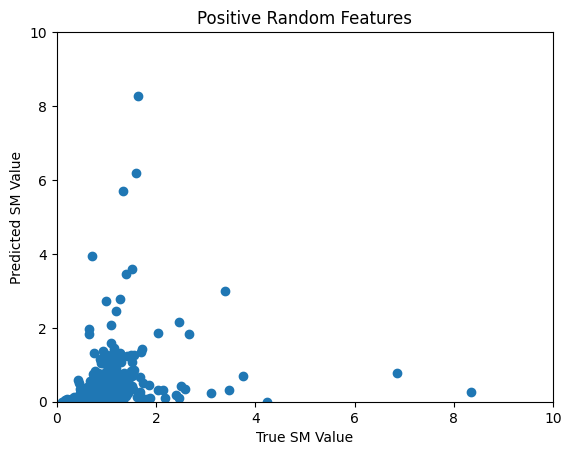

In [15]:
import matplotlib.pyplot as plt

"""
We see the extreme heteroscedasticity of the estimator; plot shows the performance of the estimator in a way MSE doesn't convey
"""

plt.scatter(true_SMs, pred_SMs_ID)
# plt.xlim(0, max(true_SMs))
# plt.ylim(0,max(true_SMs))
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('Positive Random Features')
plt.xlabel('True SM Value')
plt.ylabel('Predicted SM Value')

Text(0, 0.5, 'Predicted SM Value')

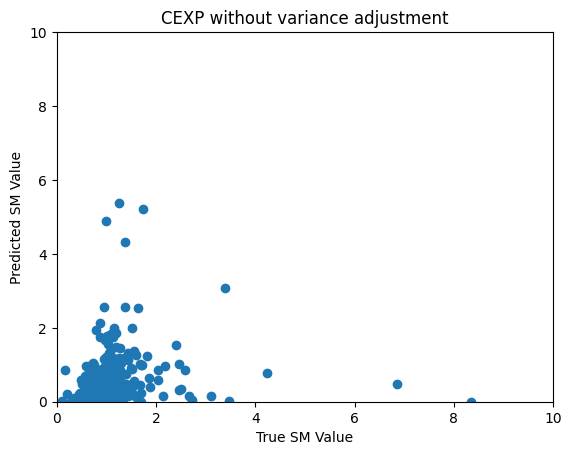

In [16]:
"""
We see the extreme heteroscedasticity of the estimator; plot shows the performance of the estimator in a way MSE doesn't convey
"""

plt.scatter(true_SMs, pred_SMs_A_no_var)
# plt.xlim(0, max(true_SMs))
# plt.ylim(0,max(true_SMs))
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('CEXP without variance adjustment')
plt.xlabel('True SM Value')
plt.ylabel('Predicted SM Value')

Text(0, 0.5, 'Predicted SM Value')

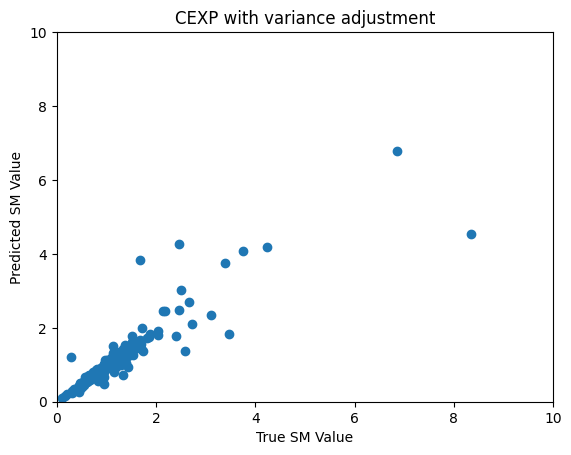

In [17]:
"""
We see the extreme heteroscedasticity of the estimator; plot shows the performance of the estimator in a way MSE doesn't convey
"""

plt.scatter(true_SMs, pred_SMs_A_var)
# plt.xlim(0, max(true_SMs))
# plt.ylim(0,max(true_SMs))
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('CEXP with variance adjustment')
plt.xlabel('True SM Value')
plt.ylabel('Predicted SM Value')

In [ ]:
np.savetxt('MREs_1', np.array(Max_relative_errors_1))
np.savetxt('MREs_2', np.array(Max_relative_errors_2))
np.savetxt('MREs_3', np.array(Max_relative_errors_3))

np.savetxt('MSEs_1', np.array(MSEs_1))
np.savetxt('MSEs_2', np.array(MSEs_2))
np.savetxt('MSEs_3', np.array(MSEs_3))


In [ ]:
Max_relative_errors_3

[11.733818141744685]

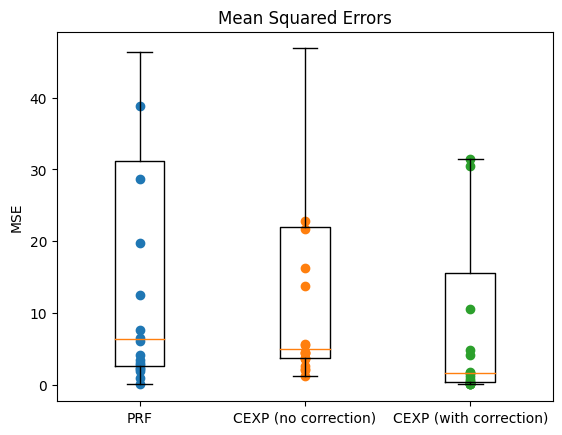

In [ ]:
dictionary = plt.boxplot((MSEs_1, MSEs_2, MSEs_3), showfliers = False,
            labels = ['PRF', 'CEXP (no correction)', 'CEXP (with correction)'])
plt.ylabel('MSE')
plt.title('Mean Squared Errors')

MSEs_1_cut = [val for val in MSEs_1 if val <=40]
x1 = len(MSEs_1_cut)*[1]

MSEs_2_cut = [val for val in MSEs_2 if val <=40]
x2 = len(MSEs_2_cut)*[2]

MSEs_3_cut = [val for val in MSEs_3 if val <=40]
x3 = len(MSEs_3_cut)*[3]

plt.scatter(x1, MSEs_1_cut)
plt.scatter(x2, MSEs_2_cut)
plt.scatter(x3, MSEs_3_cut)
# print(dictionary['fliers'][1])

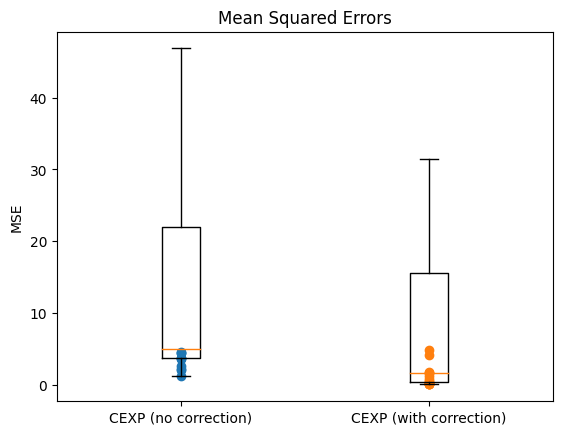

In [ ]:
dictionary = plt.boxplot((MSEs_2, MSEs_3), showfliers = False,
            labels = ['CEXP (no correction)', 'CEXP (with correction)'])
plt.ylabel('MSE')
plt.title('Mean Squared Errors')

# MSEs_1_cut = [val for val in MSEs_1 if val <=40]
# x1 = len(MSEs_1_cut)*[1]

MSEs_2_cut = [val for val in MSEs_2 if val <=5]
x2 = len(MSEs_2_cut)*[1]

MSEs_3_cut = [val for val in MSEs_3 if val <=5]
x3 = len(MSEs_3_cut)*[2]

# plt.scatter(x1, MSEs_1_cut)
plt.scatter(x2, MSEs_2_cut)
plt.scatter(x3, MSEs_3_cut)

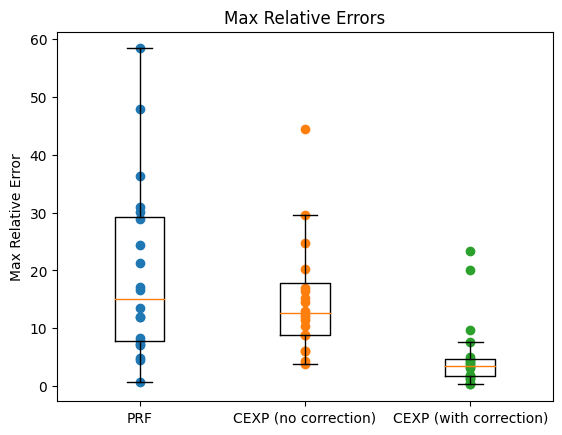

In [ ]:
plt.boxplot((Max_relative_errors_1, Max_relative_errors_2, Max_relative_errors_3), showfliers = False,
            labels = ['PRF','CEXP (no correction)', 'CEXP (with correction)'])
plt.ylabel('Max Relative Error')
plt.title('Max Relative Errors')

MREs_1_cut = [val for val in Max_relative_errors_1 if val <=100]
x1 = len(MREs_1_cut)*[1]

MREs_2_cut = [val for val in Max_relative_errors_2 if val <=100]
x2 = len(MREs_2_cut)*[2]

MREs_3_cut = [val for val in Max_relative_errors_3 if val <=100]
x3 = len(MREs_3_cut)*[3]

plt.scatter(x1, MREs_1_cut)
plt.scatter(x2, MREs_2_cut)
plt.scatter(x3, MREs_3_cut)

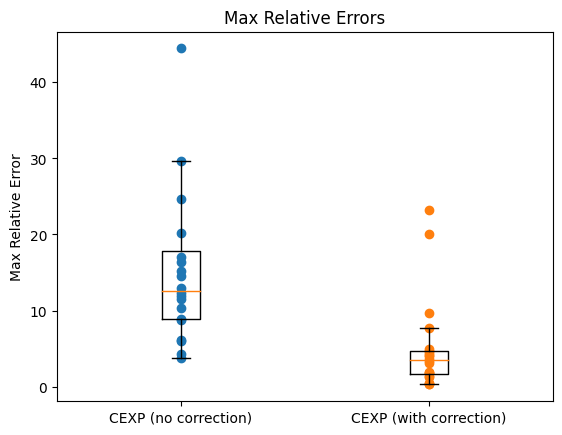

In [ ]:
plt.boxplot((Max_relative_errors_2, Max_relative_errors_3), showfliers = False,
            labels = ['CEXP (no correction)', 'CEXP (with correction)'])
plt.ylabel('Max Relative Error')
plt.title('Max Relative Errors')

# MREs_1_cut = [val for val in Max_relative_errors_1 if val <=45]
# x1 = len(MREs_1_cut)*[1]

MREs_2_cut = [val for val in Max_relative_errors_2 if val <=45]
x2 = len(MREs_2_cut)*[1]

MREs_3_cut = [val for val in Max_relative_errors_3 if val <=45]
x3 = len(MREs_3_cut)*[2]

# plt.scatter(x1, MREs_1_cut)
plt.scatter(x2, MREs_2_cut)
plt.scatter(x3, MREs_3_cut)

In [1]:
# plt.violinplot((Max_relative_errors_1, Max_relative_errors_2, Max_relative_errors_3))

In [18]:
# plt.violinplot((MSEs_1, MSEs_2, MSEs_3))